# Predict Future Sales Competition
## Top 3.5% Solution with Feature Engineering

- [Competition Link](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)
- [Reference modeling link](https://www.kaggle.com/dkomyagin/predict-future-sales-lightgbm-framework)

## This is Top 3.5% modeling code with feature engineering. I made a total of 30 featrues. If it was helpful, please upvote my code!! 👀

In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') # Ignore warning message

# date path
data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv'

#### Data Downcasting

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

## Feature Engineering I - handling sales_train, shops, items, item_categories

### sales_train: remove outliers and preprocess

In [ ]:
# Extract data with a item_price greater than 0
sales_train = sales_train[sales_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
sales_train = sales_train[sales_train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

In [ ]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

In [2]:
#  Modify shop_id in sales_train data
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

NameError: name 'sales_train' is not defined

In [3]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]

NameError: name 'test' is not defined

### Shops: create derived features and encode

In [4]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])

NameError: name 'shops' is not defined

In [5]:
shops['city'].unique()

NameError: name 'shops' is not defined

In [9]:
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [10]:
from sklearn.preprocessing import LabelEncoder

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])

In [11]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### itmes: Create derived features

In [12]:
# Remove item_name feature
items = items.drop(['item_name'], axis=1)

In [13]:
# Create the date the product was first sold as a feature
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,15.0
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [14]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
5,5,40,NaN
...,...,...,...
21975,21975,61,NaN
22022,22022,40,NaN
22028,22028,40,NaN
22035,22035,40,NaN


In [15]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

### Create item_categories derived feature and encode

In [16]:
# Extract the first word of the item_categories_name into category
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  

In [17]:
item_categories['category'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Программы      6
Музыка         6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Элементы       1
Доставка       1
Name: category, dtype: int64

In [18]:
def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc)

In [19]:
item_categories.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [20]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

# Remove item_category_name feature
item_categories = item_categories.drop('item_category_name', axis=1)

### Generate data combinations and derived features

In [21]:
from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [22]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [23]:
import gc

# group variable garbage collection
del group
gc.collect();

In [24]:
# Add a feature for the number of items sold
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# Garbage collection
del group, sales_train
gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


### Concatenate test data, Merge remaining data

In [25]:
# Set test data date_block_num to 34
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [26]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del shops, items, item_categories
gc.collect();

64.6% compressed


### Feature summary

In [27]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [28]:
resumetable(all_data)

Data Shape: (8856961, 10)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int8,0,35,0.0,0.0,0.0
shop_id,int8,0,42,59.0,59.0,59.0
item_id,int16,0,21464,22154.0,2552.0,2554.0
item_cnt_month,int16,0,407,1.0,0.0,0.0
item_price_mean,float32,0,34147,999.0,0.0,0.0
item_count,int8,0,40,1.0,0.0,0.0
city,int8,0,28,30.0,30.0,30.0
item_category_id,int8,0,84,37.0,58.0,58.0
first_sale_date,int8,0,35,0.0,0.0,0.0
category,int8,0,10,5.0,7.0,7.0


## Visualization

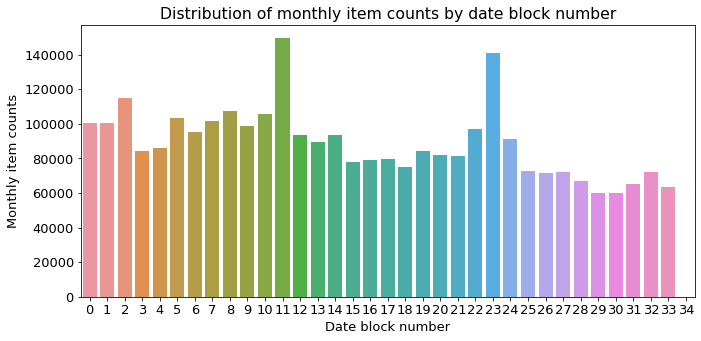

In [29]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = all_data.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

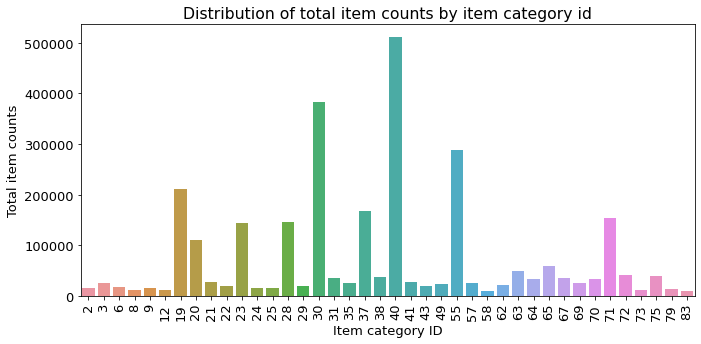

In [30]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = all_data.groupby('item_category_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='item_category_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

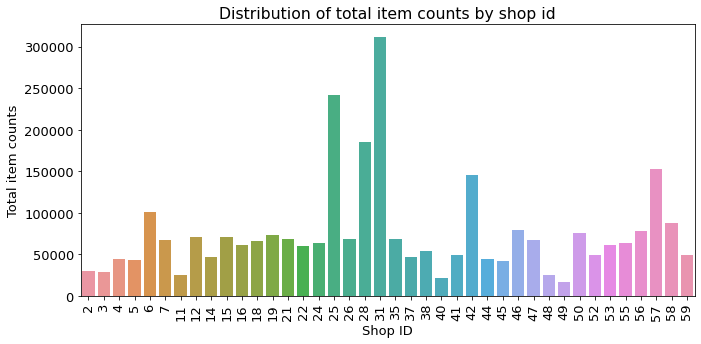

In [31]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = all_data.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

## Feature Engineering II - Create Lag features 

### Create Average Monthly Sales Derived Feature by Base Feature

In [32]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    # the assert statement is used to continue the execute if the given condition evaluates to True.
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [33]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

In [34]:
item_mean_features

['item_id_mean_sales', 'item_id_city_mean_sales']

In [35]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [36]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

### Create Lag Features

In [37]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += i
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [38]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)

In [39]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
item_price_mean,999.000000,0.000000,0.000000,0.000000,0.000000
item_count,1.000000,0.000000,0.000000,0.000000,0.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
first_sale_date,0.000000,0.000000,0.000000,0.000000,0.000000
category,5.000000,7.000000,7.000000,7.000000,7.000000


In [40]:
lag_features_to_clip

['item_cnt_month_lag1', 'item_cnt_month_lag2', 'item_cnt_month_lag3']

In [41]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [42]:
X_test_temp = all_data[all_data['date_block_num'] == 34]
X_test_temp[item_mean_features].sum()

item_id_mean_sales         0.0
item_id_city_mean_sales    0.0
dtype: float32

In [43]:
# Create lag features by item_mean_features element based on dx_features
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

In [44]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [45]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [46]:
# Remove data less than date ID 3
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

### Other Features Engineering

In [47]:
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)

In [48]:
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)

In [49]:
all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [50]:
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']

In [51]:
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

In [52]:
all_data['month'] = all_data['date_block_num']%12

In [53]:
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029765 entries, 827196 to 8856960
Data columns (total 31 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int8   
 4   city                                      int8   
 5   item_category_id                          int8   
 6   category                                  int8   
 7   item_cnt_month_lag1                       int8   
 8   item_cnt_month_lag2                       int8   
 9   item_cnt_month_lag3                       int8   
 10  item_count_lag1                           int8   
 11  item_count_lag2                           int8   
 12  item_count_lag3                           int8   
 13  item_price_mean_lag1                      float32
 1

In [54]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
del all_data
gc.collect();

## Train model and Submit

In [55]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

[LightGBM] [Info] Total Bins 3953
[LightGBM] [Info] Number of data points in the train set: 7593847, number of used features: 30
[LightGBM] [Info] Start training from score 0.307756
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01924	valid_1's rmse: 0.913885
[200]	training's rmse: 0.914524	valid_1's rmse: 0.841624
[300]	training's rmse: 0.862191	valid_1's rmse: 0.812862
[400]	training's rmse: 0.83338	valid_1's rmse: 0.801447
[500]	training's rmse: 0.814076	valid_1's rmse: 0.797531
[600]	training's rmse: 0.800453	valid_1's rmse: 0.79689
[700]	training's rmse: 0.790068	valid_1's rmse: 0.796336
[800]	training's rmse: 0.781746	valid_1's rmse: 0.795874
[900]	training's rmse: 0.774625	valid_1's rmse: 0.795648
[1000]	training's rmse: 0.768645	valid_1's rmse: 0.795829
Early stopping, best iteration is:
[897]	training's rmse: 0.774772	valid_1's rmse: 0.795568


In [56]:
preds = lgb_model.predict(X_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

In [57]:
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();

# Thank you 🙂 Upvote is free 👍